# RB1 and MCM

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re

import cptac
import cptac.utils as u

## Step 2: Find the mutation frequency of the gene of interest

In [2]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Endometrial()
desired_cutoff = 0.05
gene = 'RB1'

# Proteomics

In [3]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
omics_gene_list = ['MCM2','MCM3','MCM6']
prot_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = omics_gene_list) # single col level

In [4]:
# Step 2 - Create the binary column needed to do the comparison
prot_and_mut['RB1_mutation_status'] = prot_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
mut_wt = prot_and_mut.loc[prot_and_mut['Sample_Status'] == 'Tumor']
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_prot = mut_wt.drop(columns_to_drop, axis = 1)

In [5]:
binary_prot_melted = binary_prot.melt(id_vars='RB1_mutation_status')
binary_prot_melted

,RB1_mutation_status,Name,value
0,Wildtype,MCM2_proteomics,0.6150
1,Wildtype,MCM2_proteomics,0.9100
2,Wildtype,MCM2_proteomics,-0.0715
3,Wildtype,MCM2_proteomics,-0.5630
4,Wildtype,MCM2_proteomics,1.4100
...,...,...,...
280,Wildtype,MCM6_proteomics,0.6860
281,Wildtype,MCM6_proteomics,0.3380
282,Wildtype,MCM6_proteomics,0.9230
283,Wildtype,MCM6_proteomics,-0.4010


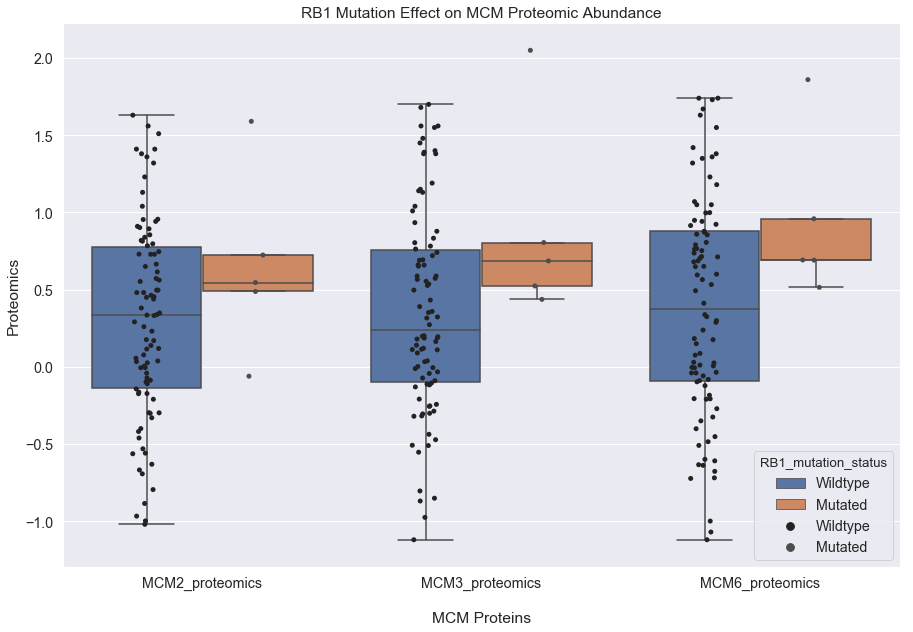

In [6]:
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.3)

boxplot = sns.boxplot(x='Name', y="value", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = binary_prot_melted, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Proteomic Abundance")
boxplot = sns.stripplot(x='Name', y="value", hue = 'RB1_mutation_status', data = binary_prot_melted, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Proteomics')

#boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation= 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Phosphopoteomics MCM

In [7]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM2')
flatten_phospho_and_mut = brain.reduce_multiindex(phos, flatten=True)

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['RB1_mutation_status'] = flatten_phospho_and_mut['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else('Normal' if x == 'Wildtype_Normal' else 'Mutated'))

# Step 3 - Format
mut_wt = flatten_phospho_and_mut.loc[flatten_phospho_and_mut['Sample_Status'] == 'Tumor'] # drop normal
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = mut_wt.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('RB1_mutation_status', axis = 1)

# keep dataframe formatted to graph with normal samples
phospho_normal = flatten_phospho_and_mut.drop(columns_to_drop, axis = 1) # includes normal samples 

In [11]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'RB1_mutation_status', phos_col_list,verbose=True)
phos_pval_results

Doing t-test comparison for mutation status
MCM2_phosphoproteomics_S108 :  0.5935806514084911
MCM2_phosphoproteomics_S139 :  0.07419030694712286
MCM2_phosphoproteomics_S170 :  nan
MCM2_phosphoproteomics_S26 :  nan
MCM2_phosphoproteomics_S27 :  0.12534303762541835
MCM2_phosphoproteomics_S31 :  nan
MCM2_phosphoproteomics_S40 :  nan
MCM2_phosphoproteomics_S41 :  0.4257912597428418
MCM2_phosphoproteomics_S53 :  0.2804550801772304
MCM2_phosphoproteomics_T39 :  nan
MCM2_phosphoproteomics_T59 :  nan
MCM2_phosphoproteomics_Y137 :  nan
MCM2_phosphoproteomics_Y90 :  nan
No significant comparisons.


In [13]:
# Create data frame with all significant phospho sites in order to graph
#phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
phospho_list = list(only_phospho.columns)

phospho_df_RB1 = pd.melt(binary_phospho, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_RB1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_RB1.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_RB1

,RB1_mutation_status,specific_phospho,phosphoproteomics
0,Wildtype,MCM2_S108,NaN
1,Wildtype,MCM2_S108,-0.433
2,Wildtype,MCM2_S108,NaN
3,Wildtype,MCM2_S108,-0.468
4,Wildtype,MCM2_S108,-0.039
...,...,...,...
1230,Wildtype,MCM2_Y90,NaN
1231,Wildtype,MCM2_Y90,NaN
1232,Wildtype,MCM2_Y90,NaN
1233,Wildtype,MCM2_Y90,NaN


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\seaborn\categorical.py:1187: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


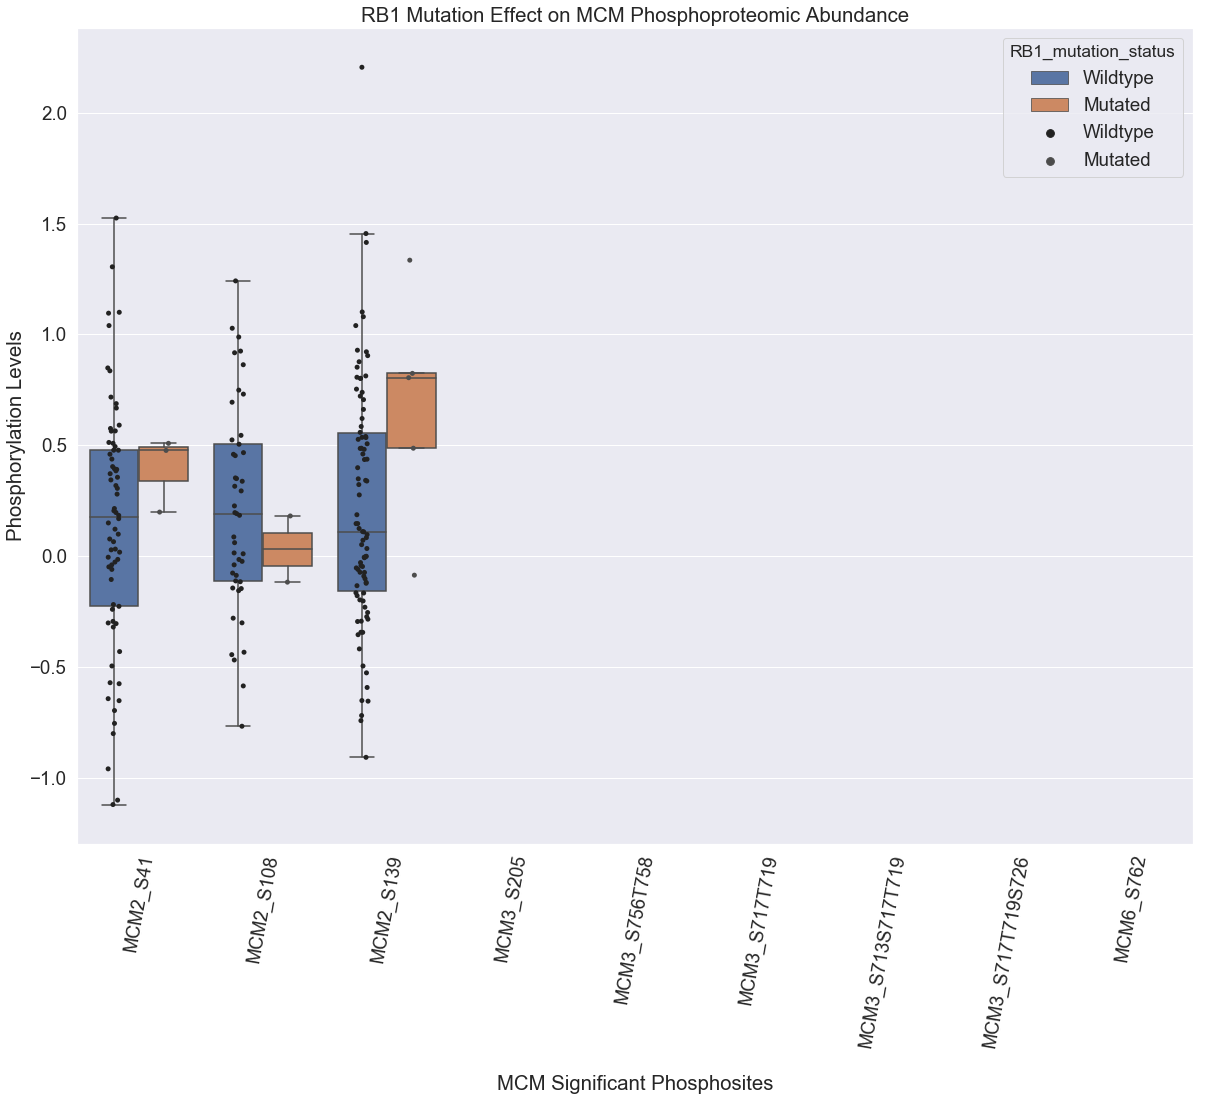

In [14]:
# Visualize 
plt.rcParams['figure.figsize']=(20,15)#size of plot
sns.set(font_scale = 1.7)

#plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                          hue_order = ['Wildtype', 'Mutated'],
                          order = ['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'],
                          data = phospho_df_RB1, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_RB1, jitter = True, 
                           color = ".3",dodge = True, hue_order = ['Wildtype', 'Mutated'],
                           order=['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'])
boxplot.set(xlabel = "\nMCM Significant Phosphosites", ylabel = 'Phosphorylation Levels')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Normalize phopho

Data already is log transformed. To normalize Phosphoproteomics - Proteomics

MCM2

In [ ]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM2')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM2_proteomics']]
mprot

In [ ]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM2')
flatten = brain.reduce_multiindex(phos, levels_to_drop=["Database_ID"], flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM2 = tumors.drop(columns_to_drop, axis = 1)
only_MCM2 = binary_MCM2.drop('RB1_mutation_status', axis = 1)
binary_MCM2['RB1_mutation_status']
only_MCM2

In [ ]:
norm = pd.DataFrame()

for i, cols in only_MCM2.iteritems():
    norm[i] = cols - mprot['MCM2_proteomics']

MCM2_df = norm.join(binary_MCM2['RB1_mutation_status']) 

In [ ]:
MCM2_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM2 phosphorylation")
MCM2_phos_pval_results = u.wrap_ttest(MCM2_df, 'RB1_mutation_status', MCM2_col_list, verbose=True)
MCM2_phos_pval_results

MCM3

In [ ]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM3')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM3_proteomics']]
mprot

In [ ]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM3')
flatten = brain.reduce_multiindex(phos, levels_to_drop=["Database_ID"], flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM3 = tumors.drop(columns_to_drop, axis = 1)
only_MCM3 = binary_MCM3.drop('RB1_mutation_status', axis = 1)
binary_MCM3['RB1_mutation_status']
only_MCM3

In [ ]:
norm = pd.DataFrame()

for i, cols in only_MCM3.iteritems():
    norm[i] = cols - mprot['MCM3_proteomics']

MCM3_df = norm.join(binary_MCM3['RB1_mutation_status']) 

In [ ]:
MCM3_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM3 phosphorylation")
MCM3_phos_pval_results = u.wrap_ttest(MCM3_df, 'RB1_mutation_status', MCM3_col_list)
MCM3_phos_pval_results

MCM6

In [ ]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM6')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM6_proteomics']]
mprot

In [ ]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM6')
flatten = brain.reduce_multiindex(phos, levels_to_drop=["Database_ID"], flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM6 = tumors.drop(columns_to_drop, axis = 1)
only_MCM6 = binary_MCM6.drop('RB1_mutation_status', axis = 1)
binary_MCM6['RB1_mutation_status']
only_MCM6

In [ ]:
norm = pd.DataFrame()

for i, cols in only_MCM6.iteritems():
    norm[i] = cols - mprot['MCM6_proteomics']

MCM6_df = norm.join(binary_MCM6['RB1_mutation_status']) 

In [ ]:
MCM6_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM6 phosphorylation")
MCM6_phos_pval_results = u.wrap_ttest(MCM6_df, 'RB1_mutation_status', MCM6_col_list)
MCM6_phos_pval_results

In [ ]:
sig = list(MCM6_phos_pval_results['Comparison'])
mcm = MCM6_df[sig].join(binary_MCM6['RB1_mutation_status'])
d = {'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK': "MCM6_S762", 
     'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK': "MCM6_S762 2!"}
mcm = mcm.rename(columns = d)
mcm

In [ ]:
# Visualize NORMALIZED
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='RB1_mutation_status', y="MCM6_S762",
                         order = ['Wildtype', 'Mutated'], data = mcm, showfliers = False)    
boxplot.set_title("RB1 Mutation Type Effect on MCM6 Normalized Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='RB1_mutation_status', y="MCM6_S762", data = mcm, jitter = True, 
                           color = ".1", order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "MCM6", ylabel = 'Normalized Phosphorylation Levels')

#boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

In [ ]:
# create csv file
mcm = mcm.reset_index()
mcm['Gene'] = 'MCM6'
d = {'Sample_ID': "Sample", 
     'MCM6_S762': "Value",
    'RB1_mutation_status':"Status"}
#mcm = mcm.rename(columns = d)
#mcm.to_csv("MCM6.csv")

In [ ]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
MCM = only_MCM2.join(only_MCM3)
MCM = MCM.join(only_MCM6)
sig_mcm = MCM[phospho_list]
norm_mcm236 = sig_mcm.join(binary_MCM6['RB1_mutation_status']) 
norm_mcm236

In [ ]:
phospho_df_MCM = pd.melt(norm_mcm236, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_MCM


In [ ]:
# Visualize NORMALIZED
plt.rcParams['figure.figsize']=(15,8) #size of plot
sns.set(font_scale = 1.3)

boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = phospho_df_MCM, showfliers = False)    
boxplot.set_title("RB1 Mutation Type effect on Normalized Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_MCM, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

In [ ]:
d = {'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK': "MCM6_S762", 
     'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK': "MCM6_S762 2!",
     'MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK': "MCM3_S205",
     'MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT*EEEMPQVHTPK': "MCM3_S756T758",
     'MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK': "MCM3_S717T719",
     'MCM3_phosphoproteomics_S713S717T719_KRS*EDES*ET*EDEEEK': "MCM3_S713S717T719",
     'MCM3_phosphoproteomics_S717T719S726_RSEDES*ET*EDEEEKS*QEDQEQK': "MCM3_S717T719S726",
     'MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAS*QR': "MCM2_S108",
     'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR': "MCM2_S139",
     'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK': "MCM2_S139 2!",
     'MCM2_phosphoproteomics_S41_RTDALTSS*PGR': "MCM2_S41"}
sig2 = sig.rename(columns = d)
